In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
trainX = np.load("/content/gdrive/MyDrive/Luna16/Processed/trainX.npy").astype(np.float32)
trainY = np.load("/content/gdrive/MyDrive/Luna16/Processed/trainY.npy").astype(np.float32)
testX = np.load("/content/gdrive/MyDrive/Luna16/Processed/testX.npy").astype(np.float32)
testY = np.load("/content/gdrive/MyDrive/Luna16/Processed/testY.npy").astype(np.float32)

In [4]:
trainX.shape

(92, 512, 512)

In [5]:
testX.shape

(23, 512, 512)

In [6]:
trainX = (trainX - 127.0)/127.0
testX = (testX - 127.0)/127.0
trainY = (trainY > 127).astype(np.float32)
testY = (testY > 127).astype(np.float32)

In [7]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


In [8]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY: ", testY.shape)

trainX:  (92, 512, 512, 1)
trainY:  (92, 512, 512, 1)
testX:  (23, 512, 512, 1)
testY:  (23, 512, 512, 1)


In [9]:
# Define Dice Coefficient and Loss
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coeff_loss(y_true, y_pred):
    return -dice_coeff(y_true, y_pred)

# Combined Loss Function
def combined_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - 0.5 * dice_coeff(y_true, y_pred)

In [10]:
# U-Net Model with Regularization and Dropout
def unet(input_size=(512, 512, 1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')

    # Encoding
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(inputs)
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv1)
    conv1 = Dropout(0.5)(conv1)  # Add dropout
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(pool1)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv2)
    conv2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(pool2)
    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(pool3)
    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(pool4)
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv5)

    # Decoding
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(up6)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv6)

    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(up7)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv7)

    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(up8)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv8)

    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(up9)
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [11]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
# Callbacks
file_path = "checkpoint-{epoch:03d}.weights.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
reduceROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor='val_loss', mode='min', patience=18)

callbacks = [checkpoint, reduceROnPlat, early, lr_scheduler]

In [13]:
# Compile Model
unet_model = unet(input_size=(512, 512, 1))
unet_model.compile(optimizer=Adam(learning_rate=2e-4), loss=combined_loss, metrics=[dice_coeff, 'accuracy'])
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 64)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 7,805,697 (29.78 MB)

 Trainable params: 7,805,697 (29.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow(trainX, trainY, batch_size=16)

In [15]:
# Train Model
history = unet_model.fit(
    train_gen,
    validation_data=(testX, testY),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8684 - dice_coeff: 8.9452e-04 - loss: 0.5981 
Epoch 1: val_loss improved from inf to 0.52753, saving model to checkpoint-001.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 262s 33s/step - accuracy: 0.8793 - dice_coeff: 9.0428e-04 - loss: 0.5947 - val_accuracy: 0.9997 - val_dice_coeff: 6.1038e-04 - val_loss: 0.5275 - learning_rate: 2.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - dice_coeff: 0.0011 - loss: 0.4585
Epoch 2: val_loss improved from 0.52753 to 0.33982, saving model to checkpoint-002.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9995 - dice_coeff: 0.0011 - loss: 0.4515 - val_accuracy: 0.9997 - val_dice_coeff: 9.5535e-04 - val_loss: 0.3398 - learning_rate: 2.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9995 - dice_coeff: 0.0018 - loss: 0.2545
Epoch 3: val_loss improved from 0.33982 to 0.23109, saving model to checkpoint-003.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s

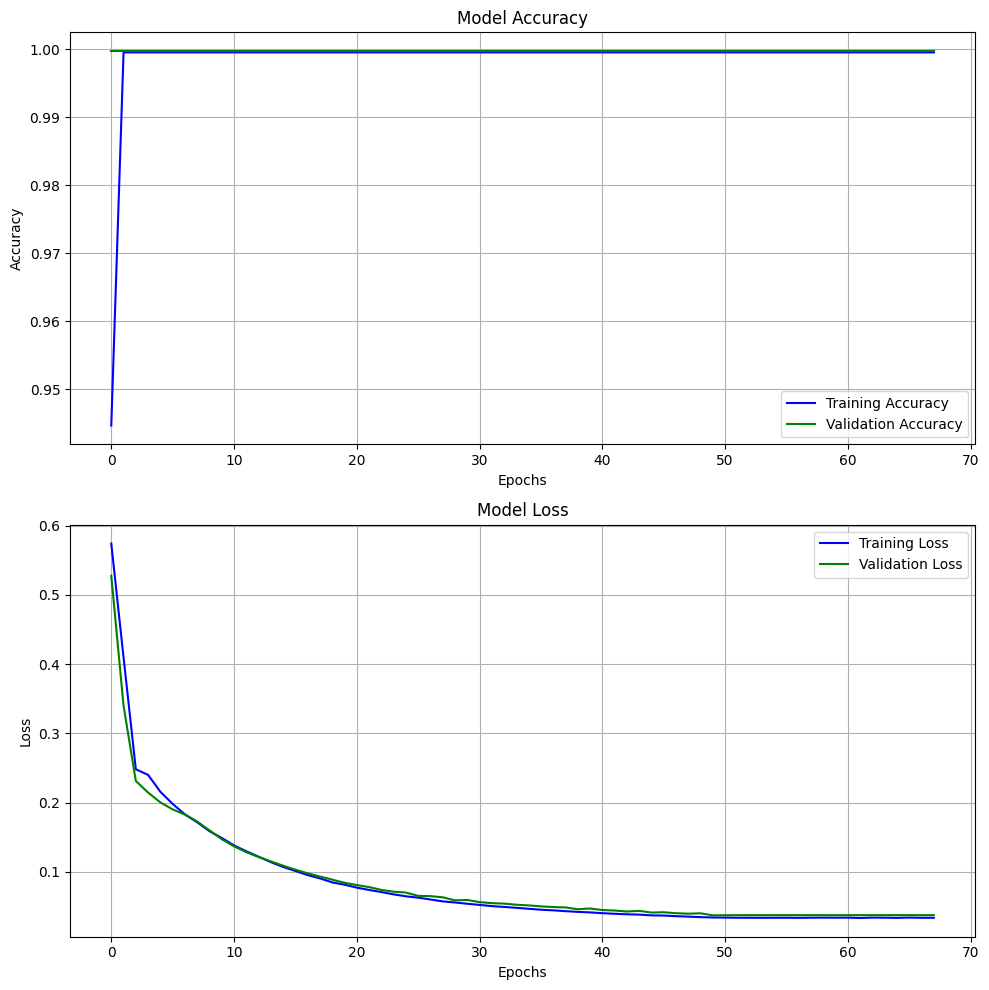

In [16]:
# Extract metrics from training
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Accuracy
ax1.plot(train_accuracy, label='Training Accuracy', color='blue')
ax1.plot(val_accuracy, label='Validation Accuracy', color='green')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot Loss
ax2.plot(train_loss, label='Training Loss', color='blue')
ax2.plot(val_loss, label='Validation Loss', color='green')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [22]:
# Step 1: Evaluate the model on the test dataset
test_accuracy = unet_model.evaluate(testX, testY, verbose=1)
test_loss = unet_model.evaluate(testX, testY, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Step 2: Make Predictions
predictions = unet_model.predict(testX)

# Convert predictions to binary (thresholding at 0.5 for binary classification)
predicted_classes = (predictions > 0.5).astype(int)

# Step 3: Get True Labels
true_labels = testY.astype(int)  # Ensure true labels are in the right format

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - accuracy: 0.9997 - dice_coeff: 0.0015 - loss: 0.0373
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.9997 - dice_coeff: 0.0015 - loss: 0.0373
Test Loss: [0.037258584052324295, 0.0014530649641528726, 0.9997264742851257]
Test Accuracy: [0.037258584052324295, 0.0014530649641528726, 0.9997264742851257]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


In [ ]:
import pickle
with open('UNET_Training', 'wb') as file_pi:
        pickle.dump(unet_model.history, file_pi)

In [24]:
unet_model.save('/content/gdrive/MyDrive/my_models/UNET.h5')